In [1]:
import io
import os
import sys
import csv
import gzip
import json
import copy
import pickle
import multiprocessing
import subprocess
import resource
import itertools
from itertools import combinations_with_replacement
import collections

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D

from scipy.stats import nbinom
from scipy.stats import geom, beta
from scipy.special import logsumexp

%cd ..
from lcSV import *

/gpfs3/well/band/users/rbx225/software/lcSV


In [5]:
## Example1: Simulating a bi-allelic site
N = 500
v = 50
l = 20
f1 = 0.05
replicates = 1
binsize = 1000

mean_coverage = 1.21
sd_coverage = 0.12

n_recomb = 200
n_iter = 500
verbose = True
premature = True

h1 = np.ones(l)
h2 = h1.copy()
h2[int(l/3):int(2*l/3)] = 0
model = SVModel([h1,h2], [1-f1,f1])
samples = np.array([f'Sample{i}' for i in range(1, N+1)])
training, coverage, true_gt = simulate_coverotron(model, N, l, mean_coverage, sd_coverage, v)

eval_dict = {}
means = np.mean(training, axis = 0)
variances = np.var(training, axis = 0, ddof = 1)
result_dict = lcSV_core(means, variances, coverage, n_recomb = n_recomb, n_iter = n_iter, verbose = verbose, premature = premature)
calling_dict = call_sv_samples(samples, true_gt)

------ Iteration 5 ------
Best loglikelihood: 146401.7152834349
------ Iteration 10 ------
Best loglikelihood: 146401.7152834349
------ Iteration 15 ------
Best loglikelihood: 146401.7152449239
------ Iteration 20 ------
Best loglikelihood: 146401.7152449239
------ Iteration 25 ------
Best loglikelihood: 146401.7152449239
------ Iteration 30 ------
Best loglikelihood: 146401.7152449239
------ Iteration 35 ------
Best loglikelihood: 146401.7152449239
------ Iteration 40 ------
Best loglikelihood: 146401.7152449239
------ Iteration 45 ------
Best loglikelihood: 146401.7152449239
------ Iteration 50 ------
Best loglikelihood: 146401.7152449239
------ Iteration 55 ------
Best loglikelihood: 146401.7152449239
------ Iteration 60 ------
Best loglikelihood: 146401.7152449239
------ Iteration 65 ------
Best loglikelihood: 146401.7152449239
------ Iteration 70 ------
Best loglikelihood: 146401.7152449239
------ Iteration 75 ------
Best loglikelihood: 146401.7152449239
------ Iteration 80 ------

In [8]:
evaluate_sim_model(result_dict, h2, true_gt)

(1.0, 1.0, 0.05299861505802068)

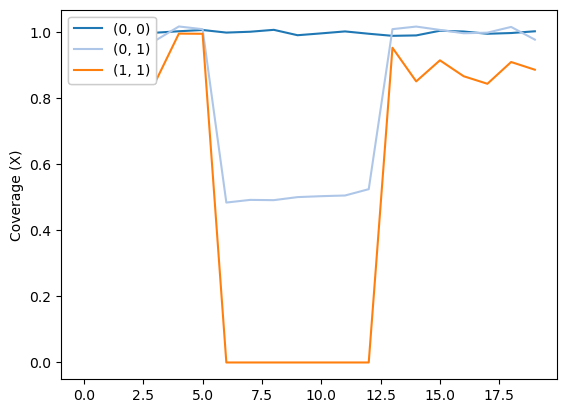

In [55]:
# plot_sv_coverage(means, coverage, samples, calling_dict)
# plot_training(result_dict)
plot_sv_coverage_by_gt(means, coverage, samples, calling_dict)

In [54]:
def plot_sv_coverage(means, coverage, samples, calling_dict):
    region = coverage/means[np.newaxis,:]
    
    colors = plt.get_cmap('tab20').colors[:10]
    colors = [mcolors.to_hex(c) for c in colors]
    
    xaxis = np.arange(coverage.shape[0])
    
    fig = plt.figure(figsize = (6,4))
    
    for i, k in enumerate(calling_dict.keys()):
        tmp_samples = calling_dict[k]
        for s in tmp_samples:
            index = np.where(samples == s)[0][0]
            
            if k == (0,0):
                plt.plot(xaxis, region[:, index], alpha = 1, color = '0.8')
            else:
                plt.plot(xaxis, region[:, index], alpha = 1, color = colors[i - 1])

    color_handles = []
    color_index = [0,0]
    for i, k in enumerate(calling_dict.keys()):
        if k != (0,0):
            color_handles.append(Line2D([0], [0], color=colors[i-1], label=k))

    legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
    legend1.get_title().set_fontsize(9)
    plt.gca().add_artist(legend1)

    plt.ylabel('Coverage (X)')
    plt.show()
    return None

def plot_sv_coverage_by_gt(means, coverage, samples, calling_dict):
    region = coverage/means[np.newaxis,:]
    
    if len(calling_dict.keys()) > 10:
        print('Only region with less than 4 different haplotypes can be printed.')
        return None
    
    colors = plt.get_cmap('tab20').colors[:10]
    colors = [mcolors.to_hex(c) for c in colors]
    xaxis = np.arange(coverage.shape[0])
    
    for i, k in enumerate(calling_dict.keys()):
        tmp_samples = calling_dict[k]
        indices = np.where(np.isin(samples, tmp_samples))[0]
        plt.plot(xaxis, region[:,indices].mean(axis = 1), alpha = 1, color = colors[i])

    color_handles = []
    color_index = [0,0]
    for i, k in enumerate(calling_dict.keys()):
        color_handles.append(Line2D([0], [0], color=colors[i], label=k))

    legend1 = plt.legend(handles=color_handles, loc='upper left', prop={'size': 10}, framealpha=1)
    legend1.get_title().set_fontsize(9)
    plt.gca().add_artist(legend1)

    plt.ylabel('Coverage (X)')
    return None